In [22]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from functions import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
import pickle
from timesformer_pytorch import TimeSformer

In [23]:

data_path = "/home/hanpeiheng/dataset/yawdd_temp/"
action_name_path = './data.pkl' #全部动作的名字标签
save_model_path = "../vivit_ckpt/"


CNN_fc_hidden1, CNN_fc_hidden2 =192, 192
lstm_input_size = 50
img_size=80
ptc_size=8
img_x, img_y = 80,80
dropout_p = 0.2  

RNN_hidden_layers = 2
RNN_hidden_nodes = 64
num1 = 16

k = 3
epochs =70 
batch_size = 31
learning_rate = 5e-4
log_interval = 10
lam=5e-4

step_size=10
gm=0.85

begin_frame, end_frame, skip_frame = 3, 98, 2

In [24]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    # set model as training mode
    en = model[0]
    en.train()

    losses = []
    scores = []
    N_count = 0
    for batch_idx, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device).view(-1, )

        N_count += X.size(0)
        
        optimizer.zero_grad()
        
        output=en(X)
        # print(re1.size())
        

        re_loss = 0
        for name, param in model[0].named_parameters():
            
            if param.requires_grad:
                re_loss += torch.sum(torch.abs(param))
        loss = F.cross_entropy(output, y,reduction='mean') + re_loss * lam
        losses.append(loss.item()) # 将该损失值添加到损失列表(losses)

        y_pred = torch.max(output, 1)[1]

        step_score = accuracy_score(y.cpu().data.squeeze().numpy(), y_pred.cpu().data.squeeze().numpy())
        scores.append(step_score)
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.2f}%'.format(
                epoch , N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item(), 100 * step_score))

    return sum(losses)/len(losses), sum(scores)/len(scores)


def validation(model, device, optimizer, test_loader,epoch):

    en = model[0]
    en.eval()

    test_loss=[]
    all_y = []
    all_y_pred = []
    with torch.no_grad():
        for X, y in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device).view(-1, )

            output=en(X)
            # 使用交叉熵损失函数计算输出结果和实际标签的损失
            re_loss = 0
            for name, param in model[0].named_parameters():
                if param.requires_grad:
                    re_loss += torch.sum(torch.abs(param))
                    
            loss = F.cross_entropy(output, y ,reduction='mean') + re_loss * lam
            # test_loss += loss.item() 
            test_loss.append(loss.item())
            y_pred = output.max(1, keepdim=True)[1]  
            

            all_y.extend(y)
            all_y_pred.extend(y_pred)

    test_loss = sum(test_loss)/len(test_loss)

    all_y = torch.stack(all_y, dim=0)
    all_y_pred = torch.stack(all_y_pred, dim=0)
    test_score = accuracy_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())

    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(len(all_y), test_loss, 100* test_score))

    torch.save(en.state_dict(), os.path.join(save_model_path, 'en_epoch{}.pth'.format(epoch)))  # save spatial_encoder
    # torch.save(de.state_dict(), os.path.join(save_model_path, 'de_epoch{}.pth'.format(epoch)))  # save motion_encoder
    torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch)))      # save optimizer
    print("Epoch {} model saved!".format(epoch + 1))
    
    
    return test_loss, test_score


use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 8, 'pin_memory': True} if use_cuda else {}

In [25]:

with open(action_name_path, 'rb') as f:
    action_names = pickle.load(f)
le = LabelEncoder()
le.fit(action_names)

list(le.classes_)

action_category = le.transform(action_names).reshape(-1, 1)

enc = OneHotEncoder()
enc.fit(action_category)


/home/hanpeiheng/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hanpeiheng/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


OneHotEncoder()

In [26]:
actions = []
# 读取指定路径（data_path）下的所有文件名
fnames = os.listdir(data_path)

all_names = []
for f in fnames:
    loc1 = f.find('s-')
    if loc1==-1:
        loc1=f.find('d-')
        
        if loc1 == -1:
            # print(loc1)
            loc1=f.find('e-')

    actions.append(f[(loc1 + 2): ])

    all_names.append(f)

all_X_list = all_names
all_y_list = labels2cat(le, actions)    # all video labels
train_list, test_list, train_label, test_label = train_test_split(all_X_list, all_y_list, test_size=0.2, random_state=4)

transform = transforms.Compose([transforms.ToTensor(),
                                # transforms.Resize([80,80]),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.229, 0.224, 0.225])])

selected_frames = np.arange(begin_frame, end_frame, skip_frame).tolist()

train_set, valid_set = Dataset_CRNN(data_path, train_list, train_label, selected_frames, transform=transform), \
                       Dataset_CRNN(data_path, test_list, test_label, selected_frames, transform=transform)

train_loader = data.DataLoader(train_set, **params)
valid_loader = data.DataLoader(valid_set, **params)
# en = Encodervis(dim=50).to(device)
# en = EncoderCNN(fc_hidden1=512, fc_hidden2=512, drop_p=dropout_p, CNN_embed_dim=lstm_input_size).to(device)
# en = ViViT(image_size=80,patch_size=16, num_classes=3,num_frames=32).to(device)
# en = ViViT_en(image_size=img_size, patch_size=ptc_size, num_classes=3, num_frames=33,dropout=dropout_p).to(device)
# de = LSTM_de(lstm_input_size=lstm_input_size, h_RNN_layers=RNN_hidden_layers, h_RNN=RNN_hidden_nodes, 
#                          num1=num1, drop_p=dropout_p, num_classes=k).to(device)
# de = DecoderRNN(lstm_input_size=lstm_input_size,hiden_layers=RNN_hidden_layers,hiden_nodes=RNN_hidden_nodes,\
                # fc_dim=num1,drop_p=dropout_p,num_classes=3).to(device)
en =  TimeSformer(dim = 64,image_size = 80,patch_size = 16,num_frames = 32,\
    num_classes = 3,depth = 3,heads = 8,dim_head =  4,\
    attn_dropout = 0.1,ff_dropout = 0.1).to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    en = nn.DataParallel(en,device_ids=[0,1]) #分配到可用的GPU上
    # de = nn.DataParallel(de) #分配到可用的GPU上
    
# 作为一个整体被优化器所优化
model_params = list(en.parameters()) 
# print(crnn_params)
optimizer = torch.optim.AdamW(model_params, lr=learning_rate)
StepLR = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gm)


Using 4 GPUs!


In [27]:
# record training process
epoch_train_losses = []
epoch_train_scores = []
epoch_test_losses = []
epoch_test_scores = []


for epoch in range(epochs):
    # train, test model
    train_losses, train_scores = train(log_interval, [en], device, train_loader, optimizer, epoch)
    epoch_test_loss, epoch_test_score = validation([en], device, optimizer, valid_loader,epoch)

    
    epoch_train_losses.append(train_losses)
    epoch_train_scores.append(train_scores)
    epoch_test_losses.append(epoch_test_loss)
    epoch_test_scores.append(epoch_test_score)


    A = np.array(epoch_train_losses)
    B = np.array(epoch_train_scores)
    C = np.array(epoch_test_losses)
    D = np.array(epoch_test_scores)
    np.save('./vivit_lstm_epoch_training_losses.npy', A)
    np.save('./vivit_lstm_epoch_training_scores.npy', B)
    np.save('./vivit_lstm_epoch_test_loss.npy', C)
    np.save('./vivit_lstm_epoch_test_score.npy', D)



Train Epoch: 0 [310/626 (48%)]	Loss: 7.301964, Accu: 32.26%
Train Epoch: 0 [620/626 (95%)]	Loss: 6.854345, Accu: 51.61%

Test set (157 samples): Average loss: 6.8269, Accuracy: 38.85%

Epoch 1 model saved!
Train Epoch: 1 [310/626 (48%)]	Loss: 6.577315, Accu: 48.39%
Train Epoch: 1 [620/626 (95%)]	Loss: 6.296116, Accu: 45.16%

Test set (157 samples): Average loss: 6.2510, Accuracy: 41.40%

Epoch 2 model saved!
Train Epoch: 2 [310/626 (48%)]	Loss: 5.825801, Accu: 54.84%
Train Epoch: 2 [620/626 (95%)]	Loss: 5.625993, Accu: 29.03%

Test set (157 samples): Average loss: 5.4998, Accuracy: 43.31%

Epoch 3 model saved!
Train Epoch: 3 [310/626 (48%)]	Loss: 5.310841, Accu: 38.71%
Train Epoch: 3 [620/626 (95%)]	Loss: 4.992517, Accu: 48.39%

Test set (157 samples): Average loss: 4.9862, Accuracy: 38.85%

Epoch 4 model saved!
Train Epoch: 4 [310/626 (48%)]	Loss: 4.679157, Accu: 41.94%
Train Epoch: 4 [620/626 (95%)]	Loss: 4.387188, Accu: 51.61%

Test set (157 samples): Average loss: 4.4041, Accuracy:

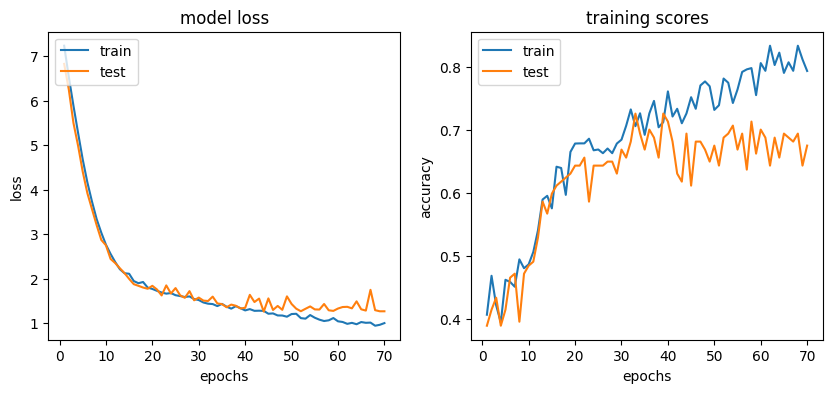

In [28]:


# plot
fig = plt.figure(figsize=(10, 4)) #创建一个10x4英寸的新窗口
plt.subplot(121) # 参数121表示将整个图形窗口分成1行2列，在第1个位置上添加子图，设为当前绘图区域

plt.plot(np.arange(1, epochs + 1), A)  # train loss (on epoch end)
plt.plot(np.arange(1, epochs + 1), C)         #  test loss (on epoch end)
plt.title("model loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc="upper left")
# 2nd figure 
#代码解释和上面的同理
plt.subplot(122)
plt.plot(np.arange(1, epochs + 1), B)  # train accuracy (on epoch end)
plt.plot(np.arange(1, epochs + 1), D)         #  test accuracy (on epoch end)
plt.title("training scores")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc="upper left")
title = "./fig_UCF101_CRNN.png"
plt.savefig(title, dpi=600)
# plt.close(fig)
plt.show()

In [29]:
import os
dirs = os.listdir("/hy-tmp/yawdd_temp/")
for dir_name in dirs:
    lst = os.listdir("/hy-tmp/yawdd_temp/"+dir_name)
    if len(lst)<100:
        print(dir_name)

FileNotFoundError: [Errno 2] No such file or directory: '/hy-tmp/yawdd_temp/'